In [38]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import json_normalize
from FCPython import createPitch
import json

In [39]:
def list_competitions():
    with open('Statsbomb/data/competitions.json') as file:
        competitions = json.load(file)
    df_competitions = pd.json_normalize(competitions)
    return df_competitions

# Call this function to see all available competitions and their details
competitions_df = list_competitions()
competitions_df[['competition_id', 'season_id', 'competition_name', 'season_name']]

,competition_id,season_id,competition_name,season_name
0,9,27,1. Bundesliga,2015/2016
1,16,4,Champions League,2018/2019
2,16,1,Champions League,2017/2018
3,16,2,Champions League,2016/2017
4,16,27,Champions League,2015/2016
...,...,...,...,...
65,55,43,UEFA Euro,2020
66,35,75,UEFA Europa League,1988/1989
67,53,106,UEFA Women's Euro,2022
68,72,107,Women's World Cup,2023


### Creating a competitions dict for finding competitions

In [40]:
def create_competitions_dict(competitions_df):
    # Initialize an empty dictionary to store competition data
    competitions_dict = {}
    
    # Loop through each row in the competitions DataFrame
    for index, row in competitions_df.iterrows():
        # Extract the competition_id and season_id from the current row
        key = (row['competition_id'], row['season_id'])
        
        # Create a dictionary containing competition_name and season_name
        value = {
            'competition_name': row['competition_name'],
            'season_name': row['season_name']
        }
        
        # Check if the combination of competition_id and season_id is not already in the dictionary
        if key not in competitions_dict:
            # If not present, add it to the dictionary with its corresponding value
            competitions_dict[key] = value
            
    # Return the populated competitions dictionary
    return competitions_dict

# Call the function to create the dictionary
competitions_dict = create_competitions_dict(competitions_df)

In [41]:
# Print the created dictionary
print("Dictionary for Finding Competition IDs:\n")
prev_competition_id = None
for key, value in competitions_dict.items():
    if key[0] != prev_competition_id:
        print("=== COMPETITION ID: ", key[0], " ===> ",value['competition_name'])
    print("Season ID:", key[1])
    print("Season:", value['season_name'])
    print()
    prev_competition_id = key[0]

Dictionary for Finding Competition IDs:

=== COMPETITION ID:  9  ===>  1. Bundesliga
Season ID: 27
Season: 2015/2016

=== COMPETITION ID:  16  ===>  Champions League
Season ID: 4
Season: 2018/2019

Season ID: 1
Season: 2017/2018

Season ID: 2
Season: 2016/2017

Season ID: 27
Season: 2015/2016

Season ID: 26
Season: 2014/2015

Season ID: 25
Season: 2013/2014

Season ID: 24
Season: 2012/2013

Season ID: 23
Season: 2011/2012

Season ID: 22
Season: 2010/2011

Season ID: 21
Season: 2009/2010

Season ID: 41
Season: 2008/2009

Season ID: 39
Season: 2006/2007

Season ID: 37
Season: 2004/2005

Season ID: 44
Season: 2003/2004

Season ID: 76
Season: 1999/2000

Season ID: 277
Season: 1972/1973

Season ID: 71
Season: 1971/1972

Season ID: 276
Season: 1970/1971

=== COMPETITION ID:  87  ===>  Copa del Rey
Season ID: 84
Season: 1983/1984

Season ID: 268
Season: 1982/1983

Season ID: 279
Season: 1977/1978

=== COMPETITION ID:  37  ===>  FA Women's Super League
Season ID: 90
Season: 2020/2021

Season I

In [42]:
# Accessing elements in the dictionary
competition_id = 12
season_id = 27

# Construct the key using competition_id and season_id
key = (competition_id, season_id)

# Accessing the value corresponding to the key
if key in competitions_dict:
    competition_info = competitions_dict[key]
    print("Competition Name:", competition_info['competition_name'])
    print("Season Name:", competition_info['season_name'])
else:
    print("Competition ID and Season ID combination not found in the dictionary.")


Competition Name: Serie A
Season Name: 2015/2016


### Load Matches

In [43]:
with open('Statsbomb/data/matches/'+str(competition_id)+'/'+str(season_id)+'.json') as f:
    matches = json.load(f)

In [44]:
len(matches)

380

In [45]:
#matches[0]

### Initialize Teams

In [46]:
# Initialize an empty set to store the team names
teams = set()

# Iterate through each match
for match in matches:
    # Add the home team name to the set
    teams.add(match['home_team']['home_team_name'])
    # Add the away team name to the set
    teams.add(match['away_team']['away_team_name'])

# Convert the set to a list if you need to sort or index the teams
team_list = list(teams)
# Optionally, sort the list alphabetically
team_list.sort()

# Print or return the list of team names
team_list

['AC Milan',
 'AS Roma',
 'Atalanta',
 'Bologna',
 'Carpi',
 'Chievo',
 'Empoli',
 'Fiorentina',
 'Frosinone',
 'Genoa',
 'Hellas Verona',
 'Inter Milan',
 'Juventus',
 'Lazio',
 'Napoli',
 'Palermo',
 'Sampdoria',
 'Sassuolo',
 'Torino',
 'Udinese']

This code is designed to analyze football (soccer) match data, specifically focusing on identifying and visualizing "danger passes" during a tournament. A "danger pass" is defined as a pass that occurs within 15 seconds leading up to a shot. The analysis involves several steps, including data extraction, filtering, and visualization, which I will explain in detail.

### Step 1: Identifying Matches Played by the Team

In [47]:
#The team we are interested in
team_required ="AC Milan"

In [48]:
match_id_required = []
for match in matches:
    home_team_name = match['home_team']['home_team_name']
    away_team_name = match['away_team']['away_team_name']
    if (home_team_name == team_required) or (away_team_name == team_required):
        match_id_required.append(match['match_id'])

- The code iterates through a list of matches (`matches`).
- For each match, it checks whether the `team_required` is either the home or away team.
- If the team participated in the match, the match's ID is added to `match_id_required`.

In [49]:
len(match_id_required) #Numbers of matches played

38

### Step 2: Analyzing Passes and Shots in Each Match

In [50]:
for ic, match_id in enumerate(match_id_required):
    # Load match events
    file_name = str(match_id) + '.json'
    with open('Statsbomb/data/events/' + file_name) as data_file:
        data = json.load(data_file)
    df = json_normalize(data, sep="_").assign(match_id=file_name[:-5])
    team_actions = (df['team_name'] == team_required)
    df = df[team_actions]

- For each match ID in `match_id_required`, the corresponding match events file is loaded.
- The data is normalized into a DataFrame (`df`), filtering for actions by `team_required`.

In [51]:
    # DataFrames for passes and shots
    passes_match = df.loc[df['type_name'] == 'Pass'].set_index('id')
    shots_match = df.loc[df['type_name'] == 'Shot'].set_index('id')

In [85]:
shots_match

,index,period,timestamp,minute,second,possession,duration,type_id,type_name,possession_team_id,...,pass_no_touch,block_deflection,clearance_left_foot,pass_deflected,50_50_outcome_id,50_50_outcome_name,dribble_nutmeg,foul_committed_penalty,foul_won_penalty,match_id
id,,,,,,,,,,,,,,,,,,,,,
24aa12fb-6fec-42cb-9477-1ed9eb5fd85c,506,1,00:13:55.556,13,55,32,0.452050,16,Shot,243,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3878542
e2f51907-2f0c-4671-b4ae-7ddbf7acf093,516,1,00:13:59.329,13,59,32,0.042138,16,Shot,243,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3878542
f4addc47-dce2-412c-b6c2-1cd35581c8ef,547,1,00:14:56.779,14,56,33,0.802218,16,Shot,243,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3878542
11d66b5f-79a7-4f75-8e42-0670a4acede2,1037,1,00:28:58.236,28,58,59,0.996950,16,Shot,243,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3878542
de52f6c2-3f81-4bea-a799-46746fd9420b,1699,2,00:03:21.860,48,21,93,1.007116,16,Shot,243,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3878542
f0da6e24-e9d8-45dc-a7b0-c9ba8e5745b5,2067,2,00:15:31.243,60,31,122,1.552458,16,Shot,243,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3878542
3db07c46-5739-4dac-93eb-d3466dab260e,2648,2,00:30:09.396,75,9,158,0.780161,16,Shot,243,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3878542
585e1358-dc3a-45ba-91c3-2959138a6df2,3200,2,00:41:19.732,86,19,178,1.354159,16,Shot,243,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3878542
292fc79e-2c4e-4b7f-94a6-9ffd5653f89a,3479,2,00:49:56.705,94,56,195,0.139353,16,Shot,243,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3878542


- Two separate DataFrames are created for passes and shots, indexed by their IDs.

In [52]:
    # Calculate shot and pass times
    shot_times = shots_match['minute'] * 60 + shots_match['second']
    shot_window = 15
    shot_start = shot_times - shot_window
    pass_times = passes_match['minute'] * 60 + passes_match['second']

1. **Calculate Shot Times in Seconds:**
   - `shot_times = shots_match['minute'] * 60 + shots_match['second']`
     - This line calculates the time at which each shot occurred in seconds. It converts the minutes to seconds and adds the remaining seconds to get the total time elapsed in seconds at the moment of each shot.

2. **Define the Shot Window:**
   - `shot_window = 15`
     - Here, `shot_window` is set to 15, which represents 15 seconds. This window is used to identify passes that occurred within 15 seconds leading up to a shot.

3. **Calculate the Start of the Shot Window:**
   - `shot_start = shot_times - shot_window`
     - This line calculates the starting point of the window for each shot. By subtracting the `shot_window` (15 seconds) from the `shot_times`, it determines the earliest time in the window where passes could be considered as leading up to the shot.

4. **Calculate Pass Times in Seconds:**
   - `pass_times = passes_match['minute'] * 60 + passes_match['second']`
     - Similar to shot times, this line calculates the time at which each pass occurred in seconds.

The purpose of these calculations is to identify "danger passes" that occur within a very specific and short timeframe leading up to a shot, indicating a direct contribution to creating a scoring opportunity.

In [53]:
    # Identify danger passes
    def in_range(pass_time, start, finish):
        return (True in ((start < pass_time) & (pass_time < finish)).unique())

    pass_to_shot = pass_times.apply(lambda x: in_range(x, shot_start, shot_times))

- A function `in_range` is defined to check if a pass occurs within the 15-seconds window before a shot.
- This function is applied to all pass times to identify danger passes.

In [54]:
    # Exclude corners and aggregate danger passes
    iscorner = passes_match['pass_type_name'] == 'Corner'
    danger_passes = passes_match[np.logical_and(pass_to_shot, np.logical_not(iscorner))]

- Passes classified as corners are excluded from danger passes.
- Danger passes are aggregated over all matches.

**Aggregating Danger Passes Across Matches:**

In [56]:
    if ic == 0:
        passes = danger_passes
    else:
        #passes = passes.append(danger_passes)
        # Use pandas.concat to concatenate the existing 'passes' DataFrame with the new 'danger_passes' DataFrame
        passes = pd.concat([passes, danger_passes], ignore_index=True)

This part of the code is dealing with aggregating "danger passes" from multiple matches into a single DataFrame and keeping track of the number of matches analyzed. Let's break it down for better understanding:

- This code block is part of the main loop iterating over matches (`match_id_required`). The variable `ic` is the loop's index, starting from 0 for the first match.
- For the first match (`if ic == 0`), the DataFrame `passes` is initialized with the DataFrame `danger_passes`, which contains all the danger passes identified for that match.
- For subsequent matches (`else`), the new `danger_passes` DataFrame is appended to the existing `passes` DataFrame. This way, `passes` accumulates danger passes from all matches.
- This approach ensures that by the end of the loop, `passes` contains all danger passes from every match played by the team.

**Printing the Number of Danger Passes for Each Match:**

In [57]:
    print('Match: ' + str(match_id) + '. Number of danger passes is: ' + str(len(danger_passes)))

Match: 3878542. Number of danger passes is: 24


- After processing each match, this line prints the `match_id` and the number of danger passes identified in that match (`len(danger_passes)`). This output helps in understanding the contribution of each match to the overall danger passes.

**Tracking the Number of Matches Analyzed:**

In [60]:
number_of_matches = ic + 1

In [61]:
number_of_matches

38


- Once the loop has finished executing, the total number of matches processed is calculated by adding 1 to the last index `ic`. This is necessary because indexing starts at 0, so to get the count of matches, we need to offset the index by 1.
- `number_of_matches` is used later in the analysis, particularly when creating heatmaps or averages per match, to normalize data or to provide context to the analysis.

### Step 3: Visualization

This part of the code is focused on visualizing the "danger passes" data collected and processed from football matches. It involves two main types of visualization: plotting individual danger passes on a pitch diagram and creating a heatmap to show the concentration of these passes. Additionally, it explores player involvement in danger passes. Let's break down each part:

### Plotting Danger Passes on a Pitch Diagram

In [62]:
#Size of the pitch in yards (!!!)
pitchLengthX=120
pitchWidthY=80

1. **Setting up the Pitch Dimensions:**
   - The pitch is defined as 120 yards in length (`pitchLengthX`) and 80 yards in width (`pitchWidthY`). These dimensions are standard for a football pitch.

2. **Creating the Pitch:**
   - `createPitch(pitchLengthX, pitchWidthY, 'yards', 'gray')` creates a visual representation of a football pitch. The function returns a figure (`fig`) and axes (`ax`) object for plotting.

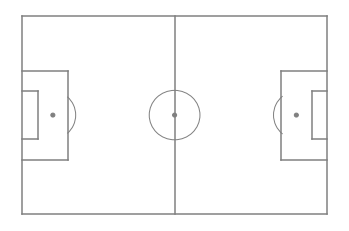

In [76]:
(fig,ax) = createPitch(pitchLengthX,pitchWidthY,'yards','gray')

In [83]:
#Plot the passes
for i,thepass in passes.iterrows():
    x=thepass['location'][0]
    y=pitchWidthY-thepass['location'][1]
    passCircle=plt.Circle((x,y),1,color="blue")      
    passCircle.set_alpha(.2)   
    ax.add_patch(passCircle)

3. **Plotting Each Danger Pass:**
   - The code iterates through each row in the `passes` DataFrame, which contains danger passes.
   - For each pass, it plots a circle at the pass's location on the pitch. The `x` and `y` coordinates are adjusted so that (0,0) is in the bottom left of the plot, inverting `y` to match the typical orientation of a football pitch in diagrams.
   - The circle's color is set to blue with a low alpha value (`set_alpha(.2)`), making it semi-transparent. This helps in visualizing overlaps without cluttering the diagram.

In [78]:
ax.set_title('Danger passes by ' + team_required)
fig.set_size_inches(10, 7)
#fig.savefig('Output/PassesBy' + team_required + '.pdf', dpi=100) 
plt.show()

4. **Finalizing the Plot:**
   - The plot's title is set, and the figure's size is adjusted for clarity.
   - The plot is saved as a PDF file, and then displayed using `plt.show()`.

### Creating a Heatmap of Danger Passes

In [66]:
#Make x,y positions
x=[]
y=[]
for i,apass in passes.iterrows():
    x.append(apass['location'][0])
    y.append(pitchWidthY-apass['location'][1])

1. **Preparing x, y Coordinates:**
   - Coordinates for each danger pass are extracted and adjusted similar to the first plot. These are used to calculate the density of passes across the pitch.

In [67]:
#Make a histogram of passes
H_Pass=np.histogram2d(y, x,bins=5,range=[[0, pitchWidthY],[0, pitchLengthX]])

2. **Calculating the Histogram:**
   - `np.histogram2d(y, x, bins=5, range=[[0, pitchWidthY], [0, pitchLengthX]])` creates a 2D histogram. This function bins the `x` and `y` coordinates into a 5x5 grid, effectively counting the number of danger passes within each bin.

(83.0, -3.0)

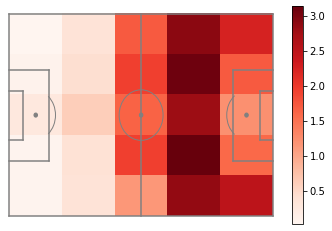

In [68]:
# createPitch
(fig,ax) = createPitch(pitchLengthX,pitchWidthY,'yards','gray')

pos=ax.imshow(H_Pass[0]/number_of_matches, extent=[0,120,0,80], aspect='auto',cmap=plt.cm.Reds)

fig.colorbar(pos, ax=ax)
#ax.set_title('Danger passes per match by ' + team_required)
plt.xlim((-1,121))
plt.ylim((83,-3))

3. **Plotting the Heatmap:**
   - The histogram data is divided by the `number_of_matches` to get an average per match, ensuring the visualization reflects the density of danger passes relative to the number of matches played.
   - `ax.imshow` plots this data as a heatmap on the pitch diagram. The color map (`cmap=plt.cm.Reds`) indicates the concentration of passes, with warmer colors representing higher densities.
   - A color bar is added for reference to the density values.

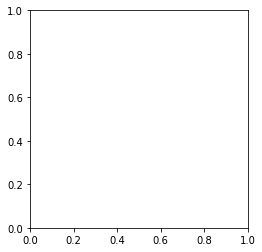

In [69]:
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

#fig.savefig('Output/HeatmapOfPasses' + team_required + '.pdf', dpi=None, bbox_inches="tight") 

4. **Adjusting the Heatmap Plot:**
   - The plot limits are set to slightly exceed the pitch dimensions to ensure the entire pitch is visible without clipping.
   - The aspect ratio is set to `equal` to maintain the correct proportions of the pitch.

### Analyzing Player Involvement

In [70]:
passes.player_name.value_counts()

Giacomo Bonaventura                 165
Riccardo Montolivo                  125
Keisuke Honda                       121
Carlos Arturo Bacca Ahumada         113
Luca Antonelli                       94
Ignazio Abate                        94
Andrea Bertolacci                    92
Juraj Kucka                          88
Mattia De Sciglio                    74
Alessio Romagnoli                    57
Luiz Adriano de Souza da Silva       37
Mario Barwuah Balotelli              37
M''Baye Babacar Niang                31
Alessio Cerci                        26
Alex Rodrigo Dias da Costa           25
Davide Calabria                      23
Andrea Poli                          18
Cristian Eduardo Zapata Valencia     16
Jérémy Ménez                         16
José Mauri                           14
Kevin-Prince Boateng                 14
Nigel de Jong                        11
Philippe Mexès                        9
Gianluigi Donnarumma                  9
Diego López Rodríguez                 6


- `passes.player_name.value_counts()` counts the number of danger passes made by each player. This simple analysis identifies which players are most involved in creating dangerous situations through passing.

### Complete code

Match: 3879628. Number of danger passes is: 41
Match: 3879665. Number of danger passes is: 61
Match: 3879585. Number of danger passes is: 47
Match: 3879562. Number of danger passes is: 24
Match: 3879836. Number of danger passes is: 54
Match: 3879781. Number of danger passes is: 27
Match: 3879771. Number of danger passes is: 28
Match: 3879756. Number of danger passes is: 16
Match: 3879742. Number of danger passes is: 27
Match: 3879869. Number of danger passes is: 32
Match: 3879858. Number of danger passes is: 48
Match: 3879851. Number of danger passes is: 56
Match: 3879846. Number of danger passes is: 34
Match: 3879824. Number of danger passes is: 23
Match: 3879810. Number of danger passes is: 14
Match: 3879805. Number of danger passes is: 32
Match: 3879791. Number of danger passes is: 44
Match: 3879758. Number of danger passes is: 31
Match: 3879734. Number of danger passes is: 47
Match: 3879721. Number of danger passes is: 39
Match: 3879712. Number of danger passes is: 34
Match: 387969

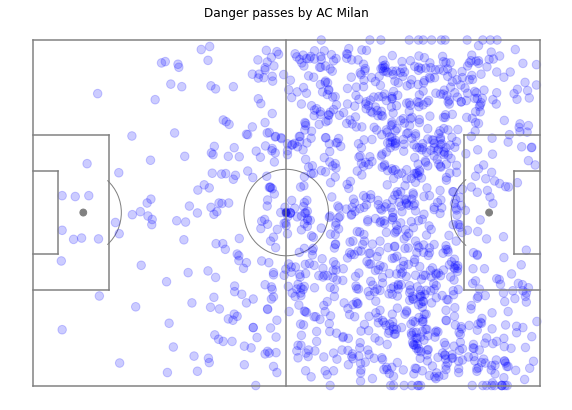

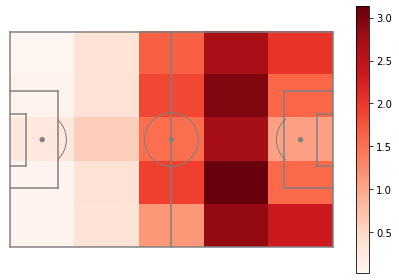

Giacomo Bonaventura                 155
Riccardo Montolivo                  125
Keisuke Honda                       117
Carlos Arturo Bacca Ahumada         109
Ignazio Abate                        94
Andrea Bertolacci                    90
Juraj Kucka                          88
Luca Antonelli                       84
Mattia De Sciglio                    70
Alessio Romagnoli                    53
Mario Barwuah Balotelli              37
Luiz Adriano de Souza da Silva       35
M''Baye Babacar Niang                31
Alessio Cerci                        26
Alex Rodrigo Dias da Costa           25
Davide Calabria                      23
Andrea Poli                          18
Cristian Eduardo Zapata Valencia     16
Jérémy Ménez                         16
José Mauri                           14
Kevin-Prince Boateng                 14
Philippe Mexès                        9
Gianluigi Donnarumma                  9
Nigel de Jong                         7
Manuel Locatelli                      4


In [71]:
#Make a heat map of all teams passes during a tournament.
# We set a window for danger passes to be those in 15 minutes leading up to a shot.

#Find the matches they played
match_id_required=[]
for match in matches:
    home_team_name=match['home_team']['home_team_name']
    away_team_name=match['away_team']['away_team_name']
    if (home_team_name==team_required) or (away_team_name==team_required):
        match_id_required.append(match['match_id'])
    
#Find the passes for each match
for ic,match_id in enumerate(match_id_required):
    
    #Load in all match events 

    file_name=str(match_id)+'.json'
    with open('Statsbomb/data/events/'+file_name) as data_file:
        data = json.load(data_file)
    df = json_normalize(data, sep = "_").assign(match_id = file_name[:-5])
    team_actions = (df['team_name']==team_required)
    df = df[team_actions]
    
    #A dataframe of passes
    passes_match = df.loc[df['type_name'] == 'Pass'].set_index('id')
    #A dataframe of shots
    shots_match = df.loc[df['type_name'] == 'Shot'].set_index('id')
    
    #Find shot times in seconds
    #This should be adjusted to account for overlapping halves of the match.
    shot_times = shots_match['minute']*60+shots_match['second']
    shot_window = 15  
    shot_start = shot_times - shot_window
    pass_times = passes_match['minute']*60+passes_match['second']
    
    #Check with passes are whitin [shot_window] seconds of a shot
    #Idea from this code came from https://stackoverflow.com/questions/38201057/efficiently-check-if-value-is-present-in-any-of-given-ranges
    def in_range(pass_time,start,finish):
        return (True in ((start < pass_time) & (pass_time < finish)).unique())

    pass_to_shot = pass_times.apply(lambda x: in_range(x,shot_start,shot_times))
    
    #Exclude corners
    iscorner = passes_match['pass_type_name']=='Corner'
    
    danger_passes=passes_match[np.logical_and(pass_to_shot,np.logical_not(iscorner))]
    
    if ic==0:
        passes =  danger_passes
    else:
        #passes = passes.append(danger_passes)
        # Use pandas.concat to concatenate the existing 'passes' DataFrame with the new 'danger_passes' DataFrame
        passes = pd.concat([passes, danger_passes], ignore_index=True)

    
    
    print('Match: ' + str(match_id) + '. Number of danger passes is: ' + str(len(danger_passes)))


#Set number of matches
number_of_matches=ic+1

#Size of the pitch in yards (!!!)
pitchLengthX=120
pitchWidthY=80

#Plot the passes
(fig,ax) = createPitch(pitchLengthX,pitchWidthY,'yards','gray')
for i,thepass in passes.iterrows():
    x=thepass['location'][0]
    y=pitchWidthY-thepass['location'][1]
    passCircle=plt.Circle((x,y),1,color="blue")      
    passCircle.set_alpha(.2)   
    ax.add_patch(passCircle)

ax.set_title('Danger passes by ' + team_required)
fig.set_size_inches(10, 7)
fig.savefig('Output/PassesBy' + team_required + '.pdf', dpi=100) 
plt.show()

#Make x,y positions
x=[]
y=[]
for i,apass in passes.iterrows():
    x.append(apass['location'][0])
    y.append(pitchWidthY-apass['location'][1])

#Make a histogram of passes
H_Pass=np.histogram2d(y, x,bins=5,range=[[0, pitchWidthY],[0, pitchLengthX]])

from FCPython import createPitch
(fig,ax) = createPitch(pitchLengthX,pitchWidthY,'yards','gray')
pos=ax.imshow(H_Pass[0]/number_of_matches, extent=[0,120,0,80], aspect='auto',cmap=plt.cm.Reds)
fig.colorbar(pos, ax=ax)
#ax.set_title('Danger passes per match by ' + team_required)
plt.xlim((-1,121))
plt.ylim((83,-3))
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

fig.savefig('Output/HeatmapOfPasses' + team_required + '.pdf', dpi=None, bbox_inches="tight") 


#Make a diagram showing which player was involved in dangerous passes.
#Extend this to count in how many of the attacks she is involved.
passes.player_name.value_counts()

    
#Challenge: improve so that only high xG (>0.07) are included.


    

